In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam, Adadelta, RMSprop, Adagrad
import keras.backend as K

In [2]:
df = pd.read_csv('datasets/wines.csv')

In [3]:
df.columns

Index(['Class', 'Alcohol', 'Malic_acid', 'Ash', 'Alcalinity_of_ash',
       'Magnesium', 'Total_phenols', 'Flavanoids', 'Nonflavanoid_phenols',
       'Proanthocyanins', 'Color_intensity', 'Hue',
       'OD280-OD315_of_diluted_wines', 'Proline'],
      dtype='object')

In [15]:
target = df['Class']
X = df.drop(['Class'], axis=1)

In [10]:
target.value_counts()

2    71
1    59
3    48
Name: Class, dtype: int64

In [11]:
import seaborn as sns 

/home/svmihar/anaconda3/envs/tensorf/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/svmihar/anaconda3/envs/tensorf/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/svmihar/anaconda3/envs/tensorf/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/home/svmihar/anaconda3/envs/tensorf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  

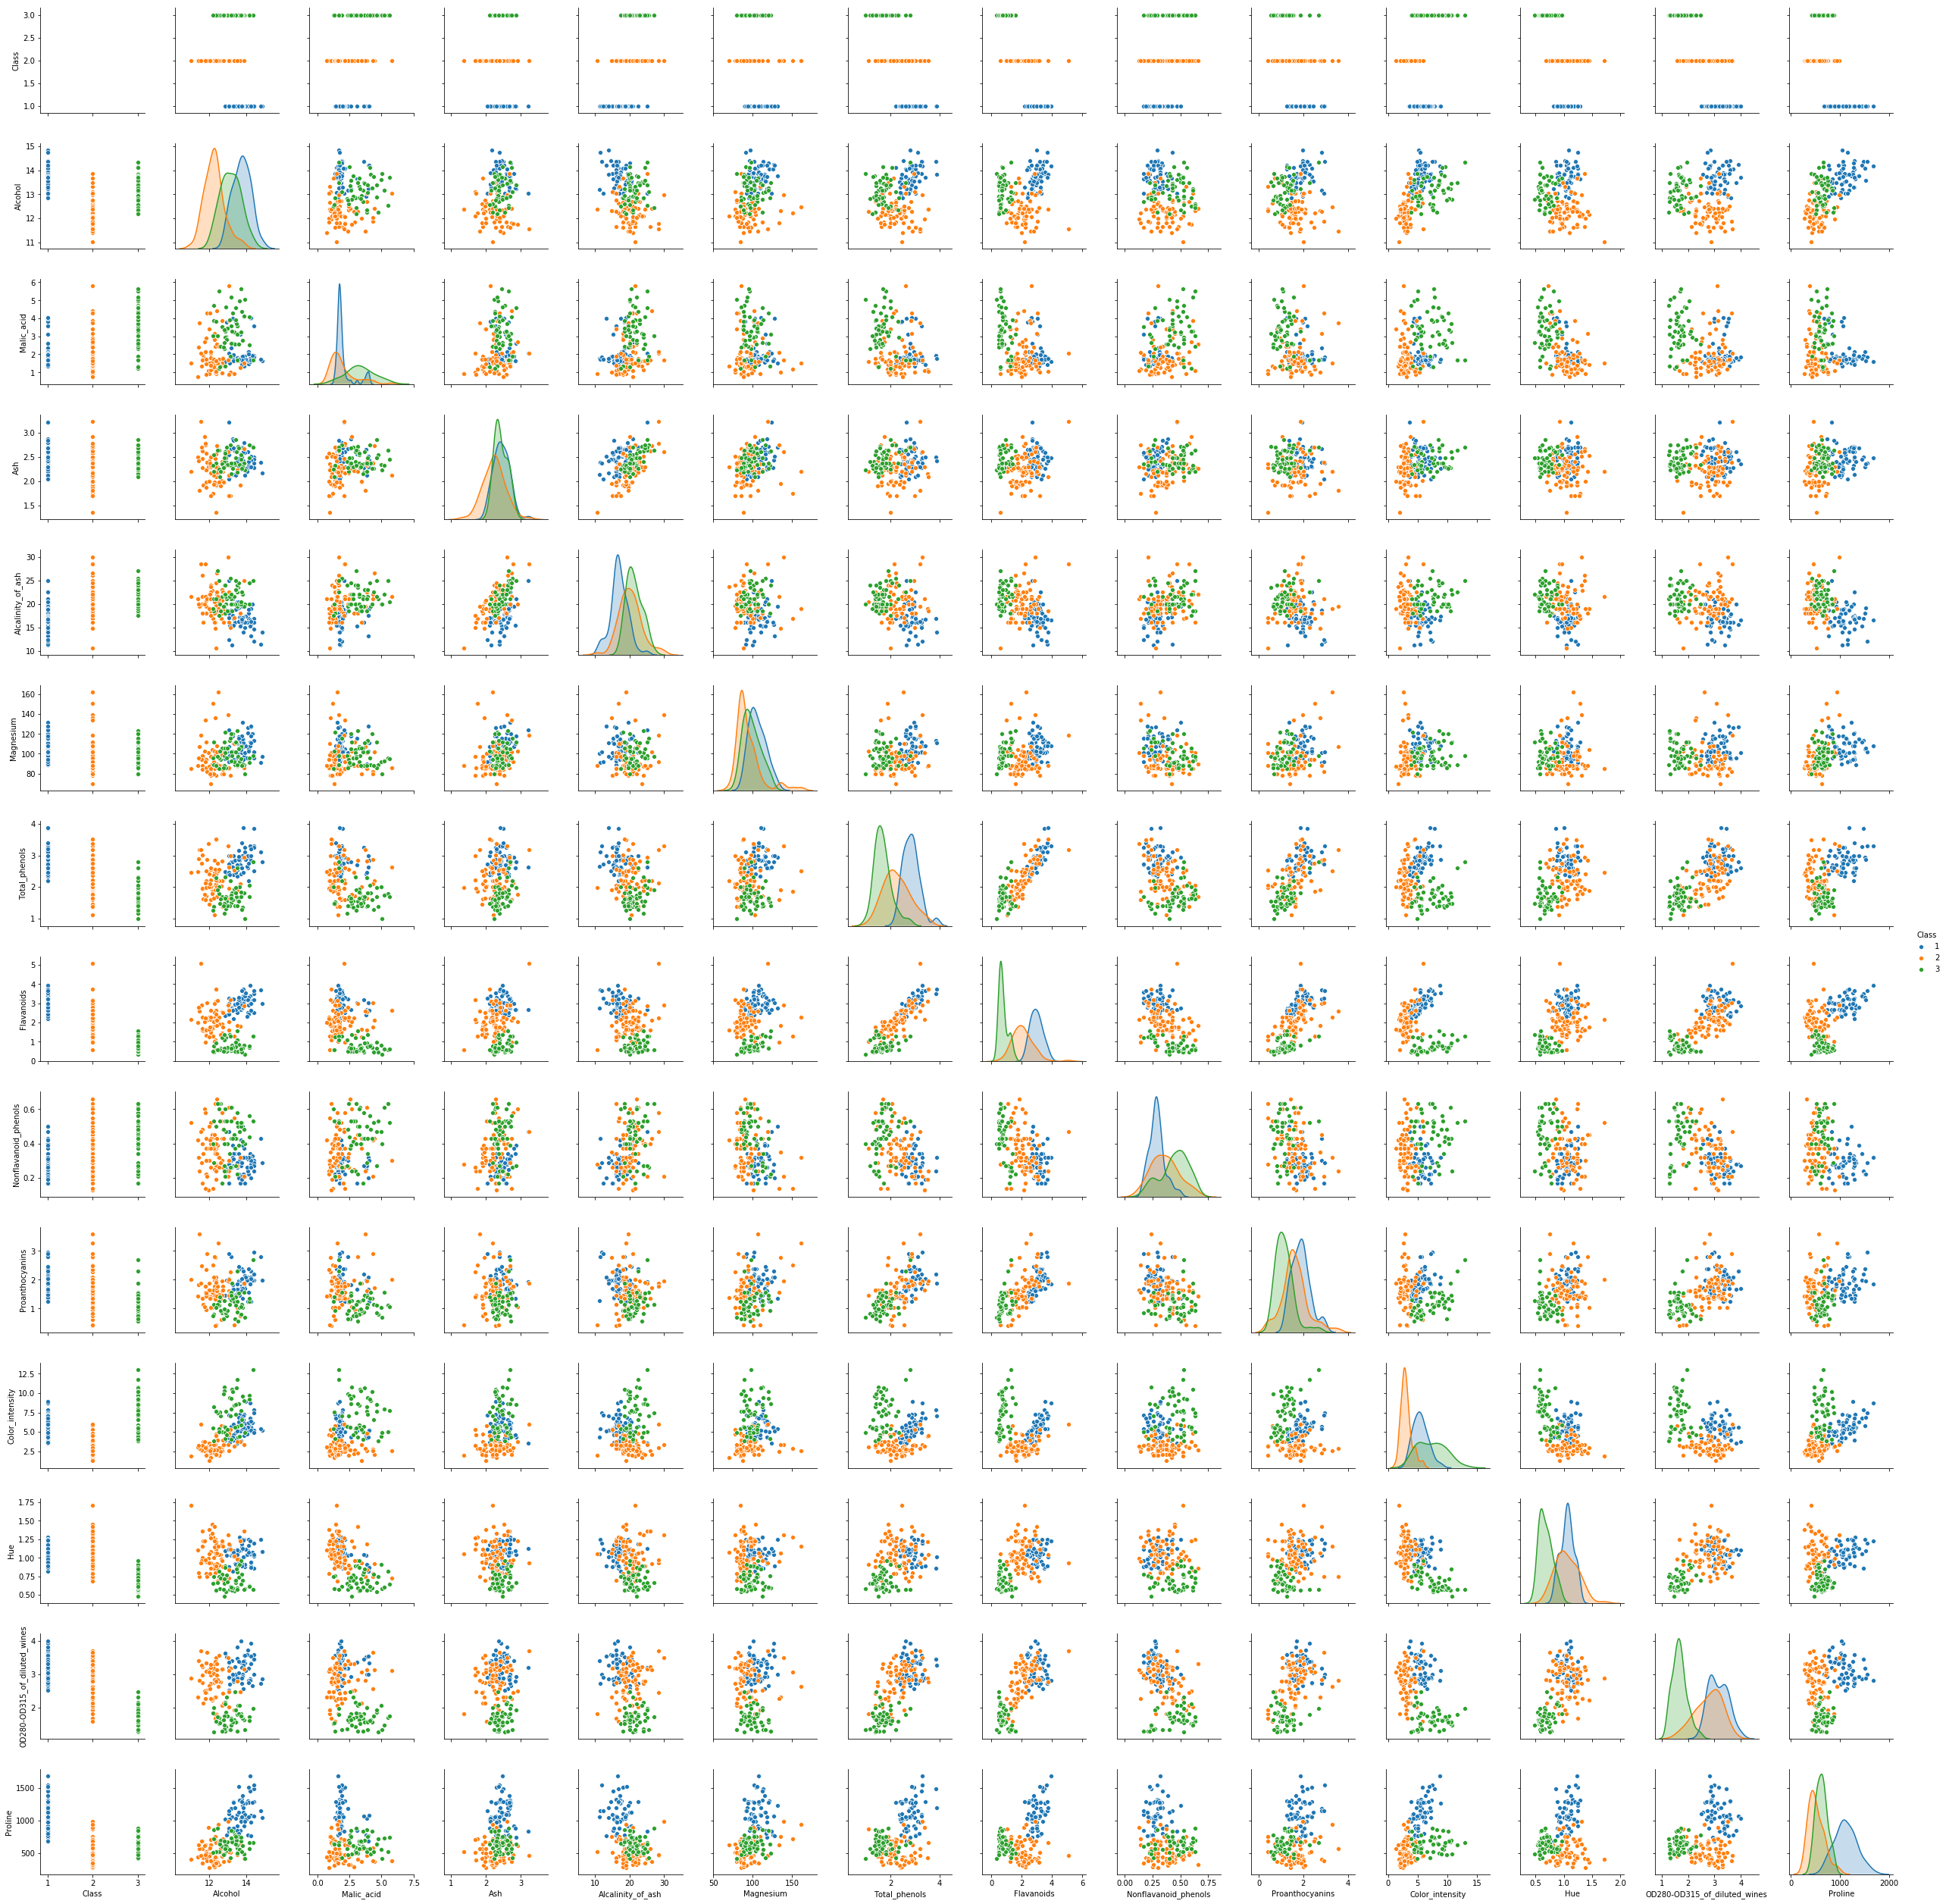

In [12]:
sns.pairplot(df, hue='Class')

In [24]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
minmax = MinMaxScaler()
sc = StandardScaler()

In [35]:
features = minmax.fit_transform(X)
y = df['Class']
y = pd.get_dummies(y)
X.describe()

/home/svmihar/anaconda3/envs/tensorf/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280-OD315_of_diluted_wines,Proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [33]:
dflist = []
batch_size=16

optimizers = ['SGD(lr = 0.01)',
              'SGD(lr = 0.01, momentum = 0.3)',
              'SGD(lr = 0.01, momentum = 0.3, nesterov = True)',  
              'Adam(lr = 0.01)',
              'Adam(lr = 0.005)',
              'Adagrad(lr = 0.01)',
              'RMSprop(lr = 0.01)']


from tqdm import tqdm
for opt_name in tqdm(optimizers):

    K.clear_session()
    
    model = Sequential()
    model.add(Dense(100, 
                    input_shape = (13,), 
                    activation = 'tanh'))
    model.add(Dense(3, 
                    activation = 'softmax'))
    
    model.compile(optimizer = eval(opt_name),
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])
    h = model.fit(features, y, 
                  batch_size = 16, 
                  epochs = 10, 
                  verbose = 0)
    
    dflist.append(pd.DataFrame(h.history, 
                               index = h.epoch))

100%|██████████| 7/7 [00:05<00:00,  1.27it/s]


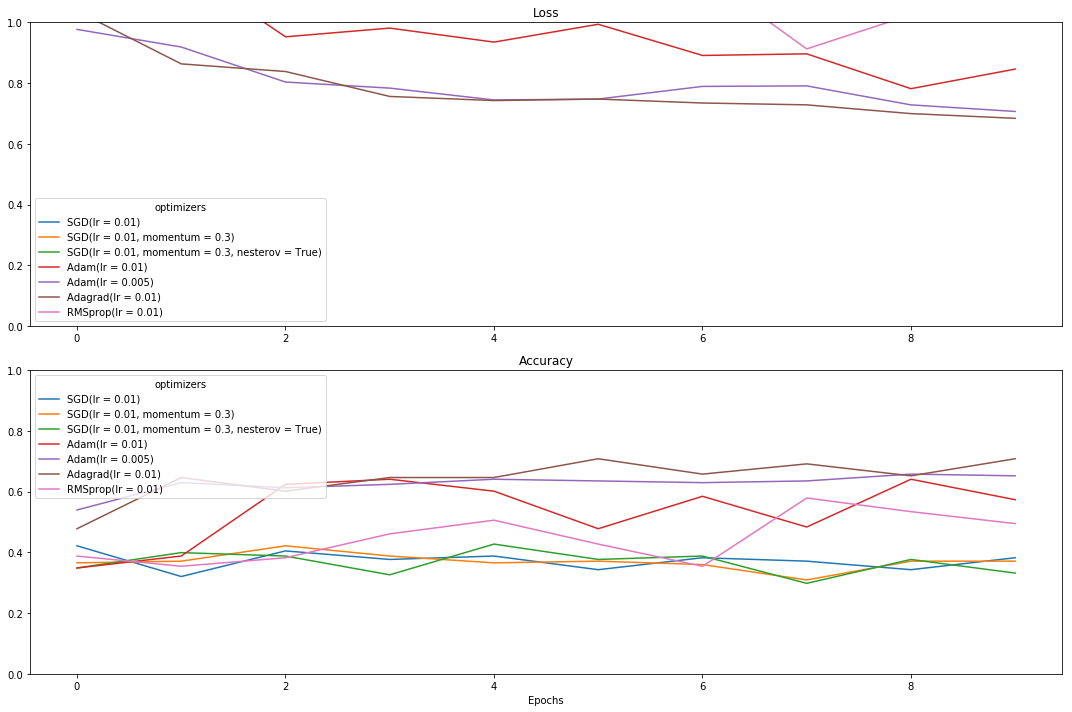

In [34]:
historydf = pd.concat(dflist, 
                      axis = 1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([optimizers, metrics_reported],
                                 names = ['optimizers', 'metric'])
historydf.columns = idx

fig, ax = plt.subplots(figsize = (15, 10))
ax = plt.subplot(211)
historydf.xs('loss', 
             axis = 1, 
             level = 'metric').plot(ylim = (0,1),
                                    ax = ax)
plt.title("Loss")

ax = plt.subplot(212)
historydf.xs('acc', 
             axis = 1, 
             level = 'metric').plot(ylim = (0,1), 
                                    ax = ax)
plt.title("Accuracy")
plt.xlabel("Epochs")

plt.tight_layout()